In [1048]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import *
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
plt.rcParams['figure.dpi'] = 100
plt.style.use('ggplot')
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
import xgboost

# from functions import col_analytics, get_score, res_2_csv

### Внутренние функции

In [1049]:
def recode_column(df_column, threshold):
    value_counts = df_column.value_counts(normalize=True)
    recoded_column = df_column.apply(lambda x: 1 if value_counts[x] >= threshold else 0)
    return recoded_column

In [1050]:
def col_analytics(col, normalize=None):
    print(f'Число NaN: {subm_df[col].isna().sum()}')
    print(f'Число уникальный значений: {subm_df[col].nunique()}')
    print(subm_df[col].value_counts(normalize=normalize))
    sns.histplot(subm_df[col])

In [1051]:
def recode_category(column, threshold, df):
    # Calculate the frequency of each category
    value_counts = df[column].value_counts(normalize=True)
    
    # Recode values below the threshold to "Other"
    df[column] = df[column].apply(lambda x: x if value_counts[x] >= threshold else 'Other')  
    return df[column]

### Данные

#### Загрузка данных

In [1052]:
df = pd.read_csv("data/train.csv")
test = pd.read_csv('data/test.csv')
subm_df=pd.concat([df,test],axis=0)
subm_df.drop('SalePrice', axis=1, inplace=True)
y_train=df['SalePrice']

In [1053]:
df.shape, test.shape, subm_df.shape

((1460, 81), (1459, 80), (2919, 80))

График цены ниже показывает, что следует модель строить для логарифмированной цены

In [1054]:
# df_num = subm_df.select_dtypes(include = ['float64', 'int64', 'int8'])
# df_num.hist(figsize=(16, 20), bins=50, xlabelsize=8, ylabelsize=8);

Будем удалять те параметры, где "перекос" в сторону конкретной категории / значения составляет более 85%

In [1055]:
# # df_cat is a DataFrame containing your categorical variables
# df_cat = subm_df.select_dtypes(include = ['object'])

# # Get the number of categorical columns
# num_cols = df_cat.shape[1]

# # Calculate the number of rows and columns for the subplot grid
# num_rows = (num_cols - 1) // 5 + 1
# num_cols = min(num_cols, 5)

# # Create a figure with subplots
# fig, axs = plt.subplots(num_rows, num_cols, figsize=(5*num_cols, 4*num_rows))

# # Flatten the axs array if it's 2D
# if num_rows > 1:
#     axs = axs.ravel()

# # Plot countplots for each categorical variable
# for i, col in enumerate(df_cat.columns):
#     sns.countplot(x=col, data=df_cat, ax=axs[i])
#     axs[i].set_title(f'Countplot of {col}')
#     axs[i].set_xlabel(col)
#     axs[i].set_ylabel('Count')

# # Remove any empty subplots
# for i in range(len(df_cat.columns), len(axs)):
#     axs[i].axis('off')

# # Adjust the layout to prevent overlap of labels
# plt.tight_layout()

# # Show the plots
# plt.show()

Аналогично, будем удалять те фичи, где "перекос" в сторону конкретной категории / значения составляет более 85%

#### Предобработка данных

In [1056]:
subm_cols = subm_df.columns.to_list()

In [1057]:
subm_df.isna().sum().to_dict()

{'Id': 0,
 'MSSubClass': 0,
 'MSZoning': 4,
 'LotFrontage': 486,
 'LotArea': 0,
 'Street': 0,
 'Alley': 2721,
 'LotShape': 0,
 'LandContour': 0,
 'Utilities': 2,
 'LotConfig': 0,
 'LandSlope': 0,
 'Neighborhood': 0,
 'Condition1': 0,
 'Condition2': 0,
 'BldgType': 0,
 'HouseStyle': 0,
 'OverallQual': 0,
 'OverallCond': 0,
 'YearBuilt': 0,
 'YearRemodAdd': 0,
 'RoofStyle': 0,
 'RoofMatl': 0,
 'Exterior1st': 1,
 'Exterior2nd': 1,
 'MasVnrType': 1766,
 'MasVnrArea': 23,
 'ExterQual': 0,
 'ExterCond': 0,
 'Foundation': 0,
 'BsmtQual': 81,
 'BsmtCond': 82,
 'BsmtExposure': 82,
 'BsmtFinType1': 79,
 'BsmtFinSF1': 1,
 'BsmtFinType2': 80,
 'BsmtFinSF2': 1,
 'BsmtUnfSF': 1,
 'TotalBsmtSF': 1,
 'Heating': 0,
 'HeatingQC': 0,
 'CentralAir': 0,
 'Electrical': 1,
 '1stFlrSF': 0,
 '2ndFlrSF': 0,
 'LowQualFinSF': 0,
 'GrLivArea': 0,
 'BsmtFullBath': 2,
 'BsmtHalfBath': 2,
 'FullBath': 0,
 'HalfBath': 0,
 'BedroomAbvGr': 0,
 'KitchenAbvGr': 0,
 'KitchenQual': 1,
 'TotRmsAbvGrd': 0,
 'Functional': 2,
 

Удаляем ненужные фичи (много пропусков, слишком большое смещение 85%+ в одну категорию), далее будем разбираться с nan

In [1058]:
bsmt_qual_mapping = {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'NA': 0}
subm_df['BsmtQual'] = subm_df['BsmtQual'].map(bsmt_qual_mapping)
exter_qual_mapping = {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1}
subm_df['ExterQual'] = subm_df['ExterQual'].map(exter_qual_mapping)
exter_cond_mapping = {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1}
subm_df['ExterCond'] = subm_df['ExterCond'].map(exter_cond_mapping)
heating_qc_mapping = {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1}
subm_df['HeatingQC'] = subm_df['HeatingQC'].map(heating_qc_mapping)
subm_df['LotFrontage']=subm_df['LotFrontage'].fillna(subm_df['LotFrontage'].mean())
subm_df['BsmtQual']=subm_df['BsmtQual'].fillna(subm_df['BsmtQual'].mode()[0])
subm_df.drop(['Street', 'Alley', 'Utilities', 'LandSlope', 'Condition2', 'RoofMatl', 'Neighborhood', 'Heating'], axis=1, inplace=True)


columns_to_transform = ['MSZoning', 'LotShape', 'LandContour', 'LotConfig', 'Condition1', 'BldgType',
                        'RoofStyle', 'MasVnrArea', 'BsmtCond', 'BsmtExposure', 'BsmtFinType2', 'BsmtFinSF2']
for col in columns_to_transform:
    most_frequent_value = subm_df[col].mode()[0]
    subm_df[col] = subm_df[col].apply(lambda x: 1 if x == most_frequent_value else 0)



columns_to_normalize = ['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
                        'YearBuilt', 'YearRemodAdd', 'ExterQual', 'ExterCond', 'BsmtFinSF1',
                        'BsmtUnfSF', 'TotalBsmtSF','BsmtQual']

for col in columns_to_normalize:
    subm_df[col] = (subm_df[col] - subm_df[col].min()) / (subm_df[col].max() - subm_df[col].min())

columns_to_transform = ['HouseStyle', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'Foundation', 'BsmtFinType1']

for column in columns_to_transform:
    value_counts = df[column].value_counts()
    most_popular_value = value_counts.index[0]
    second_popular_value = value_counts.index[1]
    subm_df[column] = subm_df[column].apply(lambda x: 2 if x == most_popular_value else (1 if x == second_popular_value else 0))

In [1059]:
col_2_delete = ['LowQualFinSF', '2ndFlrSF', 'BsmtHalfBath', 'Functional', 'WoodDeckSF', 
                'PoolArea', 'PoolQC', 'Fence', 'MiscFeature', 'MiscVal', 'CentralAir', 'Electrical', 'GarageQual', 
                'EnclosedPorch','3SsnPorch', 'ScreenPorch', 'KitchenAbvGr', 'SaleType', 'GarageCond', 'PavedDrive']

# KeyError: "['Street', 'Alley', 'Utilities', 'LandSlope', 'Condition2', 'RoofMatl', 'Neighborhood', 'Heating'] not found in axis"
len(col_2_delete)

20

In [1060]:
# удаляем колонки
subm_df = subm_df.drop(columns=col_2_delete)

In [1061]:
# columns_to_transform = ['HouseStyle', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'Foundation', 'BsmtFinType1']

# for column in columns_to_transform:
#     value_counts = df[column].value_counts()
#     most_popular_value = value_counts.index[0]
#     second_popular_value = value_counts.index[1]
#     subm_df[column] = subm_df[column].apply(lambda x: 2 if x == most_popular_value else (1 if x == second_popular_value else 0))

In [1062]:
col_2_reshape_2encoding = ['Fireplaces', 'FireplaceQu', 'HeatingQC', 'BsmtFullBath', 'KitchenQual', 
'GarageCars', 'PavedDrive', 'OpenPorchSF', 'WoodDeckSF', 'HalfBath', 'SaleCondition']

col_2_encoding = ['GarageType', 'GarageFinish', 'MoSold', 'YrSold']

Нормализация и перекодирование

In [1063]:
subm_df['SaleCondition'] = recode_category('SaleCondition', 0.05, subm_df)

In [1064]:
col_analytics

<function __main__.col_analytics(col, normalize=None)>

In [1065]:
subm_df['SaleCondition']

0        Normal
1        Normal
2        Normal
3       Abnorml
4        Normal
5        Normal
6        Normal
7        Normal
8       Abnorml
9        Normal
10       Normal
11      Partial
12       Normal
13      Partial
14       Normal
15       Normal
16       Normal
17       Normal
18       Normal
19      Abnorml
20      Partial
21       Normal
22       Normal
23       Normal
24       Normal
25       Normal
26       Normal
27       Normal
28       Normal
29       Normal
30       Normal
31       Normal
32       Normal
33       Normal
34       Normal
35       Normal
36       Normal
37       Normal
38      Abnorml
39        Other
40      Abnorml
41       Normal
42       Normal
43       Normal
44       Normal
45       Normal
46      Abnorml
47       Normal
48      Partial
49       Normal
50       Normal
51       Normal
52       Normal
53       Normal
54       Normal
55       Normal
56      Abnorml
57       Normal
58      Partial
59       Normal
60      Partial
61       Normal
62      

Число NaN: 0
Число уникальный значений: 4
SaleCondition
Normal     2402
Partial     245
Abnorml     190
Other        82
Name: count, dtype: int64


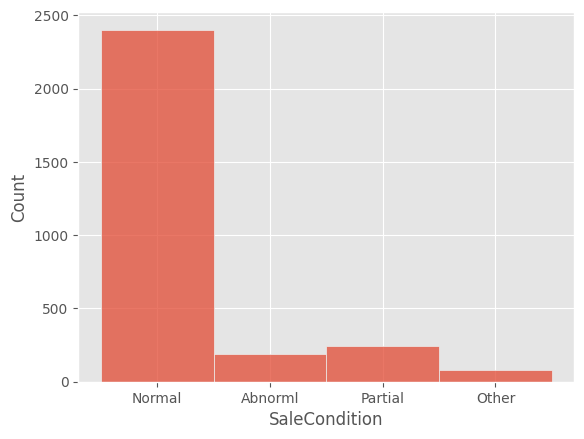

In [1066]:
col_analytics('SaleCondition')

In [1067]:
# перекодирование на 1 и 0

# Перекодирование колонки 'Fireplaces' на 1 или 0
subm_df['Fireplaces'] = subm_df['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)

subm_df['SaleCondition'] = recode_category('SaleCondition', 0.05, subm_df)

# label coding

# # Перекодирование колонки 'HeatingQC'
# HeatingQC_mapping = {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1}
# subm_df['HeatingQC'] = subm_df['HeatingQC'].map(HeatingQC_mapping)

# Перекодирование колонки 'SaleCondition'
SaleCondition_mapping = {'Normal': 1, 'Partial': 2, 'Abnorml': 3, 'Other': 4}
subm_df['SaleCondition'] = subm_df['SaleCondition'].map(SaleCondition_mapping)

# Перекодирование колонки 'FireplaceQu'
FireplaceQu_mapping = {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1}
subm_df['FireplaceQu'] = subm_df['FireplaceQu'].map(FireplaceQu_mapping)
subm_df['FireplaceQu'] = subm_df['FireplaceQu'].fillna(0)

# subm_df['FireplaceQu'] = subm_df['FireplaceQu'].apply(lambda x: 1 if x in ['Gd', 'Ex'] else 0)

# Перекодирование колонки 'KitchenQual'
kitchenqual_mapping = {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1}
subm_df['KitchenQual'] = subm_df['KitchenQual'].map(kitchenqual_mapping)

# Оставить только значения 'Attchd' и 'Detchd', остальные заменить на 'Other'
garage_mapping = {'Attchd': 'Attchd', 'Detchd': 'Detchd', 'BuiltIn': 'Other', 'Basment': 'Other',
    '2Types': 'Other', 'CarPort': 'Other'}
subm_df['GarageType'] = subm_df['GarageType'].map(garage_mapping)
subm_df['GarageType'] = subm_df['GarageType'].fillna('Other')


# Перекодирование колонки 'GarageCars' на 1 или 0
subm_df['GarageCars'] = subm_df['GarageCars'].apply(lambda x: 1 if x == 1 else 2 if x == 2 else 3 if x > 2 else 0)
# Перекодирование колонки 'OpenPorchSF' на 1 или 0
subm_df['OpenPorchSF'] = subm_df['OpenPorchSF'].apply(lambda x: 0 if x == 0 else 1)
# # Перекодирование колонки 'WoodDeckSF' на 1 или 0
# subm_df['WoodDeckSF'] = subm_df['WoodDeckSF'].apply(lambda x: 0 if x == 0 else 1)


In [1068]:
# one-hot encoding
subm_df = pd.get_dummies(subm_df, columns=col_2_encoding)
# # Применяем StandartScaler: после его применения у всех колонок среднее станет равно 0, стандартное отклонение 1
# ss_scaler = StandardScaler()
# subm_df[col_2_normalize] = ss_scaler.fit_transform(subm_df[col_2_normalize])

In [1069]:
subm_df['GarageYrBlt'] = subm_df['GarageYrBlt'].fillna(subm_df['GarageYrBlt'].mean())

col_2_normalize = ['FullBath', '1stFlrSF', 'GrLivArea', 'TotRmsAbvGrd', 'GarageYrBlt', 'GarageArea',
                   'BedroomAbvGr', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
                        'YearBuilt', 'YearRemodAdd', 'ExterQual', 'ExterCond', 'BsmtFinSF1',
                        'BsmtUnfSF', 'TotalBsmtSF','BsmtQual']

for col in col_2_normalize:
    subm_df[col] = (subm_df[col] - subm_df[col].min()) / (subm_df[col].max() - subm_df[col].min())

In [1070]:
for col in ['BsmtFinSF1', 'BsmtUnfSF', 'TotalBsmtSF', 'BsmtFullBath', 'KitchenQual', 'GarageArea']: 
    subm_df[col].fillna(0, inplace=True)  

In [1071]:
subm_df.isna().sum()

Id                   0
MSSubClass           0
MSZoning             0
LotFrontage          0
LotArea              0
LotShape             0
LandContour          0
LotConfig            0
Condition1           0
BldgType             0
HouseStyle           0
OverallQual          0
OverallCond          0
YearBuilt            0
YearRemodAdd         0
RoofStyle            0
Exterior1st          0
Exterior2nd          0
MasVnrType           0
MasVnrArea           0
ExterQual            0
ExterCond            0
Foundation           0
BsmtQual             0
BsmtCond             0
BsmtExposure         0
BsmtFinType1         0
BsmtFinSF1           0
BsmtFinType2         0
BsmtFinSF2           0
BsmtUnfSF            0
TotalBsmtSF          0
HeatingQC            0
1stFlrSF             0
GrLivArea            0
BsmtFullBath         0
FullBath             0
HalfBath             0
BedroomAbvGr         0
KitchenQual          0
TotRmsAbvGrd         0
Fireplaces           0
FireplaceQu          0
GarageYrBlt

In [1072]:
subm_df.shape, subm_df.dtypes.unique()

((2919, 71),
 array([dtype('int64'), dtype('float64'), dtype('bool')], dtype=object))

In [1073]:
X_train=subm_df.iloc[:1460,:]
X_test=subm_df.iloc[1460:,:]
X_test_id = X_test['Id']
# df_Test.drop(['SalePrice'],axis=1,inplace=True)
# X_train=df_Train.drop(['SalePrice'],axis=1)
# y_train=df_Train['SalePrice']

In [1074]:
X_train.shape, X_test.shape

((1460, 71), (1459, 71))

### Модель

In [1075]:
regressor=xgboost.XGBRegressor()
booster=['gbtree','gblinear']
base_score=[0.25,0.5,0.75,1]

In [1076]:
n_estimators = [100, 200, 300]
max_depth = [2, 3, 5, 7]
booster=['gbtree','gblinear']
learning_rate=[0.05,0.1,0.15,0.20]
# min_child_weight=[1,2,3,4]

hyperparameter_grid = {
    'n_estimators': n_estimators,
    'max_depth':max_depth,
    'learning_rate':learning_rate,
    # 'min_child_weight':min_child_weight,
    'booster':booster,
    'base_score':base_score
    }

In [1077]:
from sklearn.model_selection import RandomizedSearchCV
random_cv = RandomizedSearchCV(estimator=regressor,
            param_distributions=hyperparameter_grid,
            cv=5, n_iter=50,
            scoring = 'neg_mean_squared_error',
            n_jobs = -1,
            verbose = 5,
            return_train_score = True,
            random_state=42)

In [1078]:
X_train.shape, X_test.shape

((1460, 71), (1459, 71))

In [1079]:
X_train.dtypes.unique(), X_test.dtypes.unique()

(array([dtype('int64'), dtype('float64'), dtype('bool')], dtype=object),
 array([dtype('int64'), dtype('float64'), dtype('bool')], dtype=object))

In [1080]:
X_train.shape, X_test.shape, X_test_id.shape

((1460, 71), (1459, 71), (1459,))

In [1081]:
# надо разобраться, так делать нельзя
X_train = X_train.select_dtypes(include = ['float64', 'int64', 'bool'])
X_test = X_test.select_dtypes(include = ['float64', 'int64', 'bool'])

In [1082]:
X_train.shape, X_test.shape, X_test_id.shape

((1460, 71), (1459, 71), (1459,))

In [1083]:
X_train.isna().sum()

Id                   0
MSSubClass           0
MSZoning             0
LotFrontage          0
LotArea              0
LotShape             0
LandContour          0
LotConfig            0
Condition1           0
BldgType             0
HouseStyle           0
OverallQual          0
OverallCond          0
YearBuilt            0
YearRemodAdd         0
RoofStyle            0
Exterior1st          0
Exterior2nd          0
MasVnrType           0
MasVnrArea           0
ExterQual            0
ExterCond            0
Foundation           0
BsmtQual             0
BsmtCond             0
BsmtExposure         0
BsmtFinType1         0
BsmtFinSF1           0
BsmtFinType2         0
BsmtFinSF2           0
BsmtUnfSF            0
TotalBsmtSF          0
HeatingQC            0
1stFlrSF             0
GrLivArea            0
BsmtFullBath         0
FullBath             0
HalfBath             0
BedroomAbvGr         0
KitchenQual          0
TotRmsAbvGrd         0
Fireplaces           0
FireplaceQu          0
GarageYrBlt

### Features selection

#### Линейные способы

In [1084]:
# sns.heatmap(X_train.corr(), annot=True, fmt='.2f');

In [1085]:
df_Xy = pd.concat([X_train, y_train], axis=1)
df_Xy.shape

(1460, 72)

In [1086]:
corr = df_Xy.corr()['SalePrice'][:-1].sort_values(key=lambda x: abs(x), ascending=False)
# Set the option to display all rows
pd.set_option('display.max_rows', None)
# corr

Число NaN: 0
Число уникальный значений: 6
FireplaceQu
0.0    1420
4.0     744
3.0     592
2.0      74
1.0      46
5.0      43
Name: count, dtype: int64


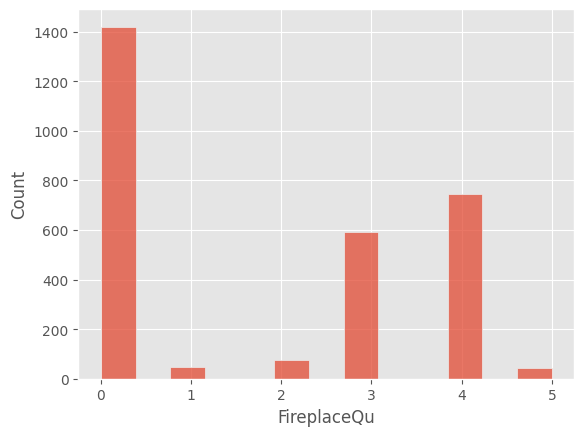

In [1087]:
col_analytics('FireplaceQu')

In [1088]:
def get_high_corr_columns(corr_series, threshold):
    high_corr_columns = corr_series[abs(corr_series) > threshold].index.tolist()
    return high_corr_columns

threshold = 0.1  # Adjust the threshold as per your requirement
high_corr_columns = get_high_corr_columns(corr, threshold)
print(high_corr_columns)

['OverallQual', 'GrLivArea', 'ExterQual', 'KitchenQual', 'BsmtQual', 'GarageCars', 'GarageArea', 'TotalBsmtSF', '1stFlrSF', 'FullBath', 'TotRmsAbvGrd', 'YearBuilt', 'FireplaceQu', 'YearRemodAdd', 'Foundation', 'Fireplaces', 'GarageYrBlt', 'HeatingQC', 'GarageFinish_Fin', 'OpenPorchSF', 'GarageFinish_Unf', 'BsmtFinSF1', 'MasVnrArea', 'GarageType_Detchd', 'GarageType_Attchd', 'LotFrontage', 'MasVnrType', 'HalfBath', 'Exterior1st', 'LotShape', 'LotArea', 'BsmtExposure', 'Exterior2nd', 'MSZoning', 'BsmtFullBath', 'RoofStyle', 'BsmtUnfSF', 'GarageFinish_RFn', 'BedroomAbvGr', 'BsmtFinType1', 'BldgType', 'BsmtFinType2', 'Condition1', 'BsmtCond']


In [1089]:
X_train.shape, X_test.shape, X_test_id.shape

((1460, 71), (1459, 71), (1459,))

#### Деревянные способы

Permutation importances

In [1090]:
from sklearn.inspection import permutation_importance
from sklearn.ensemble import RandomForestRegressor

X_train['random'] = np.random.uniform(0,100, size=X_train.shape[0])

rf = RandomForestRegressor()
rf.fit(X_train, y_train)

x_tr, x_te, y_tr, y_te = train_test_split(X_train, y_train, test_size=0.2)
r = permutation_importance(rf, x_te, y_te, n_repeats=30, random_state=0)

permutation_importances = pd.Series(dict(zip(X_train.columns, r['importances_mean']))).sort_values(key=lambda x: abs(x), ascending=False)

# Separate columns with higher and lower importances than the 'random' column
higher_importance_columns = permutation_importances[permutation_importances > permutation_importances['random']].index.tolist()
lower_importance_columns = permutation_importances[permutation_importances <= permutation_importances['random']].index.tolist()

# Print or use the lists as needed
print("Columns with higher importance than 'random':", higher_importance_columns)
print("Columns with lower importance than 'random':", lower_importance_columns)

Columns with higher importance than 'random': ['OverallQual', 'GrLivArea', 'TotalBsmtSF', 'BsmtFinSF1', '1stFlrSF', 'GarageCars', 'YearBuilt', 'GarageArea', 'LotArea', 'YearRemodAdd', 'TotRmsAbvGrd', 'OverallCond', 'BsmtQual', 'LotFrontage', 'KitchenQual', 'Id', 'GarageYrBlt', 'BsmtUnfSF']
Columns with lower importance than 'random': ['random', 'FireplaceQu', 'BedroomAbvGr', 'GarageType_Detchd', 'FullBath', 'LotShape', 'BsmtExposure', 'SaleCondition', 'ExterQual', 'MSSubClass', 'HalfBath', 'GarageFinish_Unf', 'HeatingQC', 'Exterior2nd', 'MSZoning', 'MasVnrType', 'LandContour', 'MoSold_7', 'GarageType_Attchd', 'YrSold_2007', 'MoSold_3', 'MoSold_8', 'OpenPorchSF', 'BsmtFullBath', 'ExterCond', 'GarageFinish_RFn', 'Exterior1st', 'Foundation', 'YrSold_2009', 'Condition1', 'Fireplaces', 'MoSold_11', 'RoofStyle', 'MoSold_10', 'BsmtFinType1', 'MasVnrArea', 'GarageFinish_Fin', 'MoSold_6', 'LotConfig', 'YrSold_2008', 'HouseStyle', 'GarageType_Other', 'YrSold_2006', 'YrSold_2010', 'BldgType', 'Bs

#### Сокращаем датасет за счет малозначимых фич

In [1091]:
X_train.shape, X_test.shape

((1460, 72), (1459, 71))

Убираем факторы с низкой корреляцией (линейный способ)

In [1092]:
# X_train = X_train.iloc[:, high_corr_columns]
# X_test = X_test.iloc[:, high_corr_columns]

Или убираем факторы с малой значимостию для RF

In [1093]:
X_train = X_train.loc[:, higher_importance_columns]
X_test = X_test.loc[:, higher_importance_columns]
X_train.shape, X_test.shape

((1460, 18), (1459, 18))

In [1094]:
y_train_log = np.log(y_train)

In [1095]:
# random_cv.fit(X_train,y_train)
random_cv.fit(X_train,y_train_log)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[13:02:35] WARNING: ../src/learner.cc:767: 
Parameters: { "max_depth" } are not used.

[CV 1/5] END base_score=0.75, booster=gblinear, learning_rate=0.15, max_depth=3, n_estimators=200;, score=(train=-0.264, test=-0.390) total time=   0.2s
[13:02:35] WARNING: ../src/learner.cc:767: 
Parameters: { "max_depth" } are not used.

[13:02:35] WARNING: ../src/learner.cc:767: 
Parameters: { "max_depth" } are not used.

[CV 4/5] END base_score=0.75, booster=gblinear, learning_rate=0.05, max_depth=7, n_estimators=200;, score=(train=-0.553, test=-0.536) total time=   0.2s
[13:02:35] WARNING: ../src/learner.cc:767: 
Parameters: { "max_depth" } are not used.

[CV 2/5] END base_score=0.75, booster=gblinear, learning_rate=0.15, max_depth=3, n_estimators=200;, score=(train=-0.263, test=-0.283) total time=   0.2s
[13:02:35] WARNING: ../src/learner.cc:767: 
Parameters: { "max_depth" } are not used.

[CV 5/5] END base_score=0.75, booster=gblinear, learning_rate=0.05, max_depth=7, n_estimators=200;, score=

RandomizedSearchCV(cv=5,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, gpu_id=None,
                                          grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=...
                                          n_estimators=100, n_jobs=None,
                                          num_parallel_tree=None,
                                          predictor=None, random_state=None, ...),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'base_score': [0.25, 0.5, 0.75, 1],
                                        'booster': ['gbtree', 'gblinear'],
                                        'learning_rate': [0.05, 0.1, 0.15, 0.2],
                                        'max_depth': [2, 3, 5, 7],
                                        'n_estimators': [100, 200, 300]},
                   random_state=42, return_train_score=True,
                   scoring='neg_mean_squared_error', verbose=5)

In [1096]:
from sklearn.metrics import mean_squared_error
def get_score(model, X, y):
    model.fit(X, y.ravel())

    # Получаем предсказания на тестовых данных
    y_pred = (model.predict(X))
    # y_pred = np.exp(model.predict(X))

    # Вычисляем среднеквадратическую ошибку (MSE)
    mse = mean_squared_error(y, y_pred)

    # Получаем корень из MSE, чтобы получить RMSE
    rmse = np.sqrt(mse)

    return f'Значение метрики RMSE: {rmse}'

In [1097]:
from sklearn.inspection import permutation_importance
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import f_regression, chi2

In [1098]:
get_score(random_cv, X_train, y_train_log)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[13:03:49] WARNING: ../src/learner.cc:767: 
Parameters: { "max_depth" } are not used.

[13:03:49] WARNING: ../src/learner.cc:767: 
Parameters: { "max_depth" } are not used.

[13:03:49] WARNING: ../src/learner.cc:767: 
Parameters: { "max_depth" } are not used.

[13:03:49] WARNING: ../src/learner.cc:767: 
Parameters: { "max_depth" } are not used.

[13:03:49] WARNING: ../src/learner.cc:767: 
Parameters: { "max_depth" } are not used.

[13:03:49] WARNING: ../src/learner.cc:767: 
Parameters: { "max_depth" } are not used.

[13:03:49] WARNING: ../src/learner.cc:767: 
Parameters: { "max_depth" } are not used.

[13:03:49] WARNING: ../src/learner.cc:767: 
Parameters: { "max_depth" } are not used.

[CV 1/5] END base_score=0.75, booster=gblinear, learning_rate=0.15, max_depth=3, n_estimators=200;, score=(train=-0.264, test=-0.390) total time=   0.1s
[13:03:49] WARNING: ../src/learner.cc:767: 
Parameters: { "max_depth" } are not used.

[C

'Значение метрики RMSE: 0.09623926687210206'

In [1099]:
X_test.shape, X_train.shape

((1459, 18), (1460, 18))

In [1100]:
# y_pred = (random_cv.predict(X_test))
y_pred = np.exp((random_cv.predict(X_test)))

In [1101]:
y_pred.mean(), y_pred.shape, X_test_id.shape

(169894.94, (1459,), (1459,))

In [374]:
# Сохраняем DataFrame в CSV-файл
# df_last_40.to_csv('subm_df_last_40.csv', index=False)

In [375]:
# df_num = df.select_dtypes(include = ['float64', 'int64'])
# df_num.hist(figsize=(16, 20), bins=50, xlabelsize=8, ylabelsize=8);

In [421]:
def res_2_csv(id_column, predictions_column, file_name='submission.csv'):
    # Создаем DataFrame из переданных столбцов
    df = pd.DataFrame({ 'Id': id_column, 'SalePrice': predictions_column })
    # Сохраняем DataFrame в CSV-файл
    df.to_csv(file_name, index=False)

# # res_2_csv(test['Id'], y_hat)

In [1102]:
res_2_csv(X_test_id, y_pred)